<a href="https://colab.research.google.com/github/aydanmufti/Module-7-Assignments/blob/main/Homework_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 01: Binary Classification with Neural Networks

## Due: Sunday September 7 @ 11:59 (with 2-hour grace period) and worth 85 points

In this assignment, you'll build your first deep learning models using **Keras**, a high-level deep learning framework built on TensorFlow.

We’ll solve a binary classification task, using the Wisconsin Breast Cancer dataset.

You’ll start by training a simple baseline model, and then explore a series of alternate network designs.  For each model, you’ll:

- Track training loss and accuracy over epochs
- Report final test set performance (loss and accuracy)

The goal is to begin developing an intuition for how network design choices influence performance—and to get comfortable with the end-to-end modeling workflow in Keras.


There are 12 graded problems, each worth 7 points, and you get 1 point free.


In [1]:
# Useful Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential

random_seed = 42

In [2]:
# Utility function: Plotting Training Loss (x-entropy) and Accuracy
# We'll replace this with a different function train_and_test when we develop more
# training techniques.

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')


## Prelude: Load and Explore the Wisconsin Breast Cancer Dataset

You should **always** perform EDA when working with a new dataset. We've seen this one before, but its always worth becoming familiar with the data before building a model!

In [3]:
# Load dataset with as DataFrame for EDA
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True)

df = data.frame  # Convenient alias for combined data+target

In [6]:
# Uncomment and look at this

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

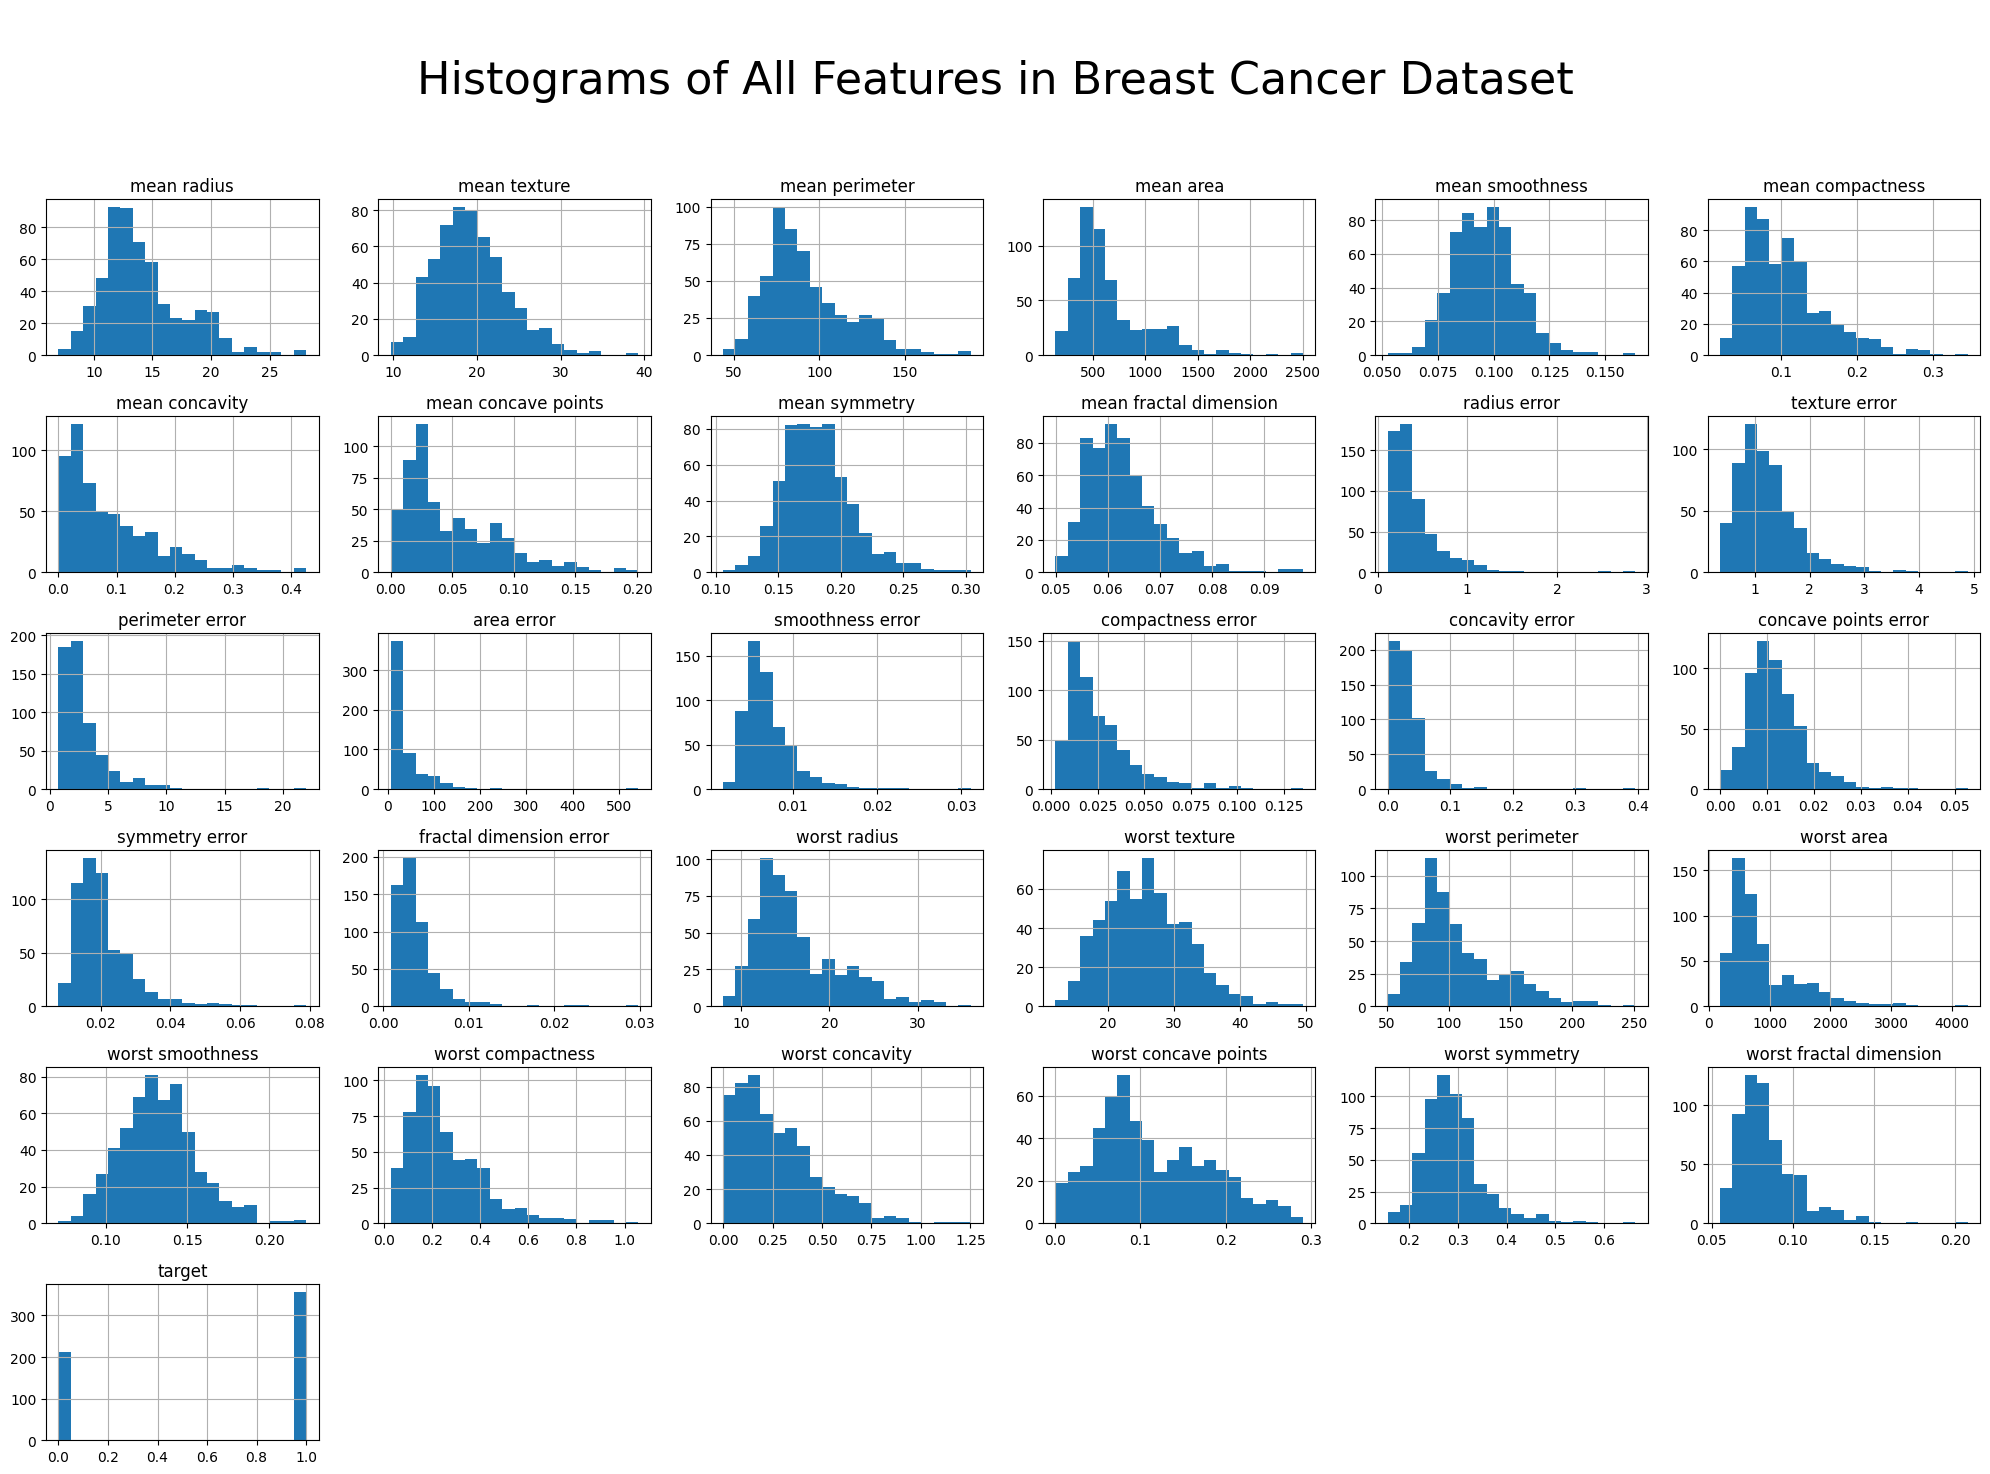

In [7]:
# Uncomment and look at this

fig = df.hist(bins=20, figsize=(20, 15), layout=(6, 6))
plt.suptitle("\nHistograms of All Features in Breast Cancer Dataset", fontsize=32)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
plt.show()

## Problem One: Dealing with unbalanced target variables and establishing a baseline model

### Part A: Compute the imbalance of the target

Neural networks work best with standardized datasets; for classification tasks, it is also important
to account for an unbalanced target. Let's create our `X,y` data structure and look at the target more closely.

1. **Convert the data to NumPy arrays:** Extract the feature matrix `X` and the target vector `y` from the DataFrame, and
convert them to NumPy arrays. Print the shapes of `X` and `y` to confirm the conversion was successful.  

2. **Check for class imbalance:**
   Use `Counter` (or another appropriate method) to print the frequency of each class label in the target array `y`. This will help you understand how balanced (or imbalanced) the classes are.

3. **Compute the proportion of class 1:**
   Calculate what percentage of the samples belong to class label `1` and provide your answer in the graded question.



In [8]:
# A.1

#Your code here
# Extracting features (all columns except 'target') then converting to NumPy array
X = df.drop('target', axis=1).values

# Extract target column and convert to NumPy array
y = df['target'].values

# Print shapes to confirm conversion
print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")

# Additional info about the arrays
print(f"\nX data type: {X.dtype}")
print(f"y data type: {y.dtype}")
print(f"\nFirst few values of y: {y[:10]}")

Shape of X (features): (569, 30)
Shape of y (target): (569,)

X data type: float64
y data type: int64

First few values of y: [0 0 0 0 0 0 0 0 0 0]


In [9]:
# A.2

# Your code here
# Count the frequency of each class label
class_counts = Counter(y)
print("Class distribution:")
print(f"Class 0 (malignant): {class_counts[0]} samples")
print(f"Class 1 (benign): {class_counts[1]} samples")

# Calculate the percentages
total_samples = len(y)
class_0_pct = (class_counts[0] / total_samples) * 100
class_1_pct = (class_counts[1] / total_samples) * 100

print(f"\nClass distribution (percentages):")
print(f"Class 0 (malignant): {class_0_pct:.1f}%")
print(f"Class 1 (benign): {class_1_pct:.1f}%")

# Calculate the class imbalance ratio
minority_class = min(class_counts.values())
majority_class = max(class_counts.values())
imbalance_ratio = majority_class / minority_class

print(f"\nImbalance ratio (majority:minority): {imbalance_ratio:.2f}:1")


Class distribution:
Class 0 (malignant): 212 samples
Class 1 (benign): 357 samples

Class distribution (percentages):
Class 0 (malignant): 37.3%
Class 1 (benign): 62.7%

Imbalance ratio (majority:minority): 1.68:1


In [12]:
# A.3

# Set a1a to the percentage (a float between 0 and 1) of 1's in the target
# Use an expression, not constants derived from inspecting the data

a3answer = np.sum(y == 1) / len(y)

a1a = a3answer             # Replace 0.0 with your answer
print(f"Proportion of class 1: {a1a:.4f}")
print(f"Percentage of class 1: {a1a * 100:.1f}%")

Proportion of class 1: 0.6274
Percentage of class 1: 62.7%


In [13]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a:.4f}')

a1a = 0.6274


### Part B: Perform a stratified test/train split

In classification problems with imbalanced datasets, it's important to address the class imbalance so that the model doesn't become biased toward the majority class. There are two common strategies:

* **Resampling** the dataset to balance the classes (by oversampling the minority class or undersampling the majority class).
* **Adjusting the loss function** so that errors on minority classes have more influence during training.

In this problem, you'll explore the second approach—using class weights to influence how the model learns.

This strategy involves two key steps:

1. **Preserve class proportions in the train/test split**
   Use the  parameter `stratify=y`in `train_test_split` to ensure that both the training and testing sets maintain the same class distribution as in the original target.

2. **Apply class weighting during training**
   Use the `class_weight` parameter in the `fit` function to assign different weights to each class when computing the loss. This helps ensure that the model pays appropriate attention to both common and rare classes.


**We'll do the first step now, perform standardization, and then do the second step in Part C.**

In [14]:
# Perform train-test split, keeping both stratified, use random_state = random_seed and test_size = 0.2

# Your code here
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=random_seed,
    stratify=y
)

print(f"Training set shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test set shape: X_test {X_test.shape}, y_test {y_test.shape}")


Training set shape: X_train (455, 30), y_train (455,)
Test set shape: X_test (114, 30), y_test (114,)


**(Digression:** We must perform standardization **after** the test/train split, or else we're letting
information about the mean and standard deviation of the test set influence training--a classic case of *data leakage*.
**)**

In [15]:
# As usual, standardize the features

# Your code here
# Defining and fitting the scaler on only training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using the same scaler (fitted on training data)
X_test_scaled = scaler.transform(X_test)

print("Features standardized successfully")
print(f"Training data mean: {X_train_scaled.mean():.6f}")
print(f"Training data std: {X_train_scaled.std():.6f}")


Features standardized successfully
Training data mean: -0.000000
Training data std: 1.000000


Let's see if the stratification worked! Assign `a1b` to the percentage of 1's in `y_train` (and convince yourself that if it is approximately correct, then so must be `y_test`).

In [16]:
# Set a1b to the percentage (a float between 0 and 1) of 1's in the target
# Use an expression, not constants derived from inspecting the data

a1b = np.sum(y_train == 1) / len(y_train)             # Replace 0.0 with your answer

In [17]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1b = {a1b:.4f}')

a1b = 0.6264


## Part C: Train a baseline model with class weighting

Now we'll build a baseline model with class weighting during training.

To compute the weight for class $i$, use the following formula:

$$
\text{weight}_i = \frac{n}{k \cdot n_i},
$$

where:

* $n$ is the total number of samples,
* $n_i$ is the number of samples in class $i$,
* $k$ is the total number of classes.

This formula scales the loss so that each class contributes approximately equally during training—without changing the number of training samples.

To apply class weighting during training, we use the parameter `class_weight=weights` in the `fit` function, where `weights` is a dictionary

    { 0 : weight_0, 1 : weight_1 }

as specified in the formula above.

**Note**: As an alternative, you can also use `sklearn.utils.class_weight` to do the calculation.

**TODO: Complete the template to**

-  Build a network consisting of a single logistic regression classifier (done for you!)
-  Compile it using the same parameters as shown in the coding video, except we will use the `Adam` optimizer:
>          optimizer='adam'
-  Train it for **100** epochs, calculating the class weights explicitly as shown or using `sklearn.utils.class_weight` (look up the docs!)
-  Display the training loss and accuracy curves using `plot_history`
-  Complete the graded question

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

Model compiled confirmed
Class weights: {0: np.float64(1.338235294117647), 1: np.float64(0.7982456140350878)}
Class 0 weight: 1.3382
Class 1 weight: 0.7982
Training the model:
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7925 - loss: 0.5083   
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8300 - loss: 0.4698 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8384 - loss: 0.4004 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8614 - loss: 0.3737 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8697 - loss: 0.3597 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8931 - loss: 0.3240 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9264 - loss: 0.2731 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8880 - loss: 0.3227 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9108 - loss: 0.2789 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

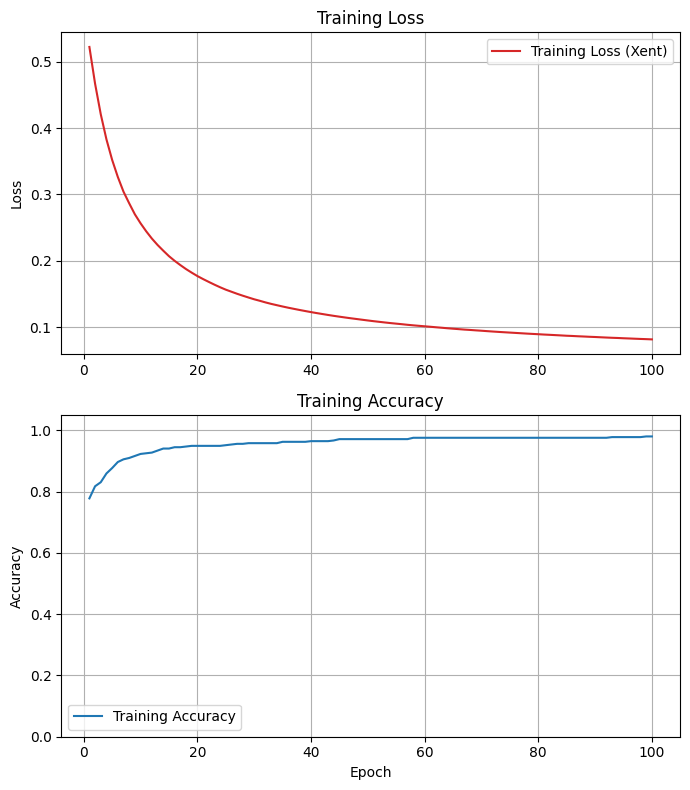

Final Training Loss:     0.0814
Final Training Accuracy: 0.9802


In [19]:
# Try a baseline model consisting of a single logistic regression classifier.
# This is very similar to sklearn's LogisticRegression model.

n_epochs = 100

# We use Sequential to build a simple classification network from
# a list of layers, and print the summary

# Uncomment this when you have defined X_train:


model_baseline = keras.Sequential(
    [
       keras.layers.Input(shape=(X_train.shape[1],)),     # Explicit input layer
       keras.layers.Dense(1, activation="sigmoid")
    ]
)


# Your code here, add additional cells if you wish
# Print model summary
model_baseline.summary()

# Compile the model
model_baseline.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model compiled confirmed")

# Calculate class weights using the formula: weight_i = n / (k * n_i)
n = len(y_train)  # total number of samples
k = 2  # number of classes (0 and 1)
n_0 = np.sum(y_train == 0)  # samples in class 0
n_1 = np.sum(y_train == 1)  # samples in class 1

weight_0 = n / (k * n_0)
weight_1 = n / (k * n_1)

class_weights = {0: weight_0, 1: weight_1}

print(f"Class weights: {class_weights}")
print(f"Class 0 weight: {weight_0:.4f}")
print(f"Class 1 weight: {weight_1:.4f}")

# Train the model
print("Training the model:")
history_baseline = model_baseline.fit(
    X_train_scaled, y_train,
    epochs=n_epochs,
    class_weight=class_weights,
    verbose=1
)
print("Training completed")
# Plot training history
plot_history(history_baseline)



In [20]:
# Set a1c to the final training accuracy (at epoch 100)
# You MUST use an expression here, not a constant from inspecting the results

a1c = history_baseline.history['accuracy'][-1]             # Replace 0.0 with your answer

In [21]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1c = {a1c:.4f}')

a1c = 0.9802


### Part D: Testing

- Calculate the testing loss and accuracy and answer the graded question.
- Print out both with appropriate labels
- Answer the graded question

In [22]:
# Your code here
# Evaluate model on test data
test_loss, test_accuracy = model_baseline.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Testing Loss: {test_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Compare with training results
print(f"\nComparison:")
print(f"Training Accuracy: {history_baseline.history['accuracy'][-1]:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Difference (Train - Test): {history_baseline.history['accuracy'][-1] - test_accuracy:.4f}")


Testing Loss: 0.1034
Testing Accuracy: 0.9649

Comparison:
Training Accuracy: 0.9802
Testing Accuracy: 0.9649
Difference (Train - Test): 0.0153


In [23]:
# Set a1d to the final testing accuracy
# Use the appropriate variable; do not insert a constant from inspection of the results

a1d = test_accuracy             # Replace 0.0 with your answer

In [24]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1d = {a1d:.4f}')

a1d = 0.9649


## Problem Two: Explore alternate network designs

For the remaining problems, you will experiment with several different network designs.

For Problem Two, redo the work you did in Parts C and D of Problem One, but with a network with a single hidden layer of 16 neurons, using the sigmoid activation function, which
will have the following summary chart (the layer name may be different than shown here):

![Screenshot 2025-05-14 at 9.53.39 PM.png](attachment:289e078f-0957-43a2-b756-1b11145abf9a.png)


Then answer the graded questions.

Model architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513 (2.00 KB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 0 (0.00 B)

Model compiled confirmed
Using class weights: {0: np.float64(1.338235294117647), 1: np.float64(0.7982456140350878)}
Training the model:
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6601 - loss: 0.6403   
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7892 - loss: 0.5729 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8629 - loss: 0.4967 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8758 - loss: 0.4744 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9409 - loss: 0.3739 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9312 - loss: 0.3544 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9433 - loss: 0.3234 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9400 - loss: 0.3042 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9409 - loss: 0.2830 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9416 - loss: 0.2785 
E

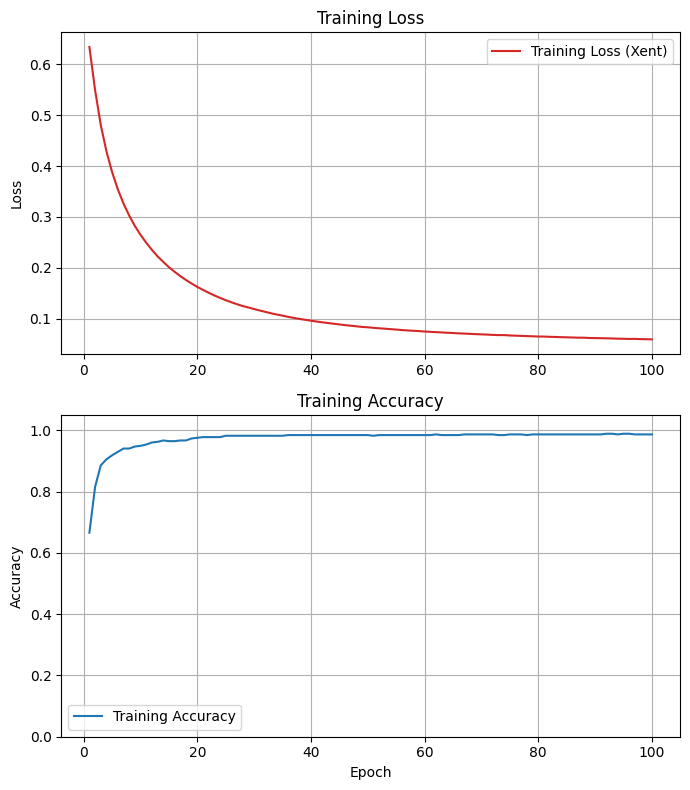

Final Training Loss:     0.0594
Final Training Accuracy: 0.9868

Results:
Training Accuracy: 0.9868
Testing Accuracy: 0.9474
Difference (Train - Test): 0.0394


In [26]:
# Your code here, add additional cells if you wish

# Goal: build a network with a single hidden layer of 16 neurons using sigmoid activation
# Build the model
model_hidden = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(16, activation="sigmoid"),  # Hidden layer with 16 neurons
    keras.layers.Dense(1, activation="sigmoid")    # Output layer
])

# Print model summary
print("Model architecture:")
model_hidden.summary()

# Compile the model (same parameters as baseline)
model_hidden.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model compiled confirmed")

# Use the same class weights as before
print(f"Using class weights: {class_weights}")

# Train the model
print("Training the model:")
history_hidden = model_hidden.fit(
    X_train_scaled, y_train,
    epochs=n_epochs,
    class_weight=class_weights,
    verbose=1
)

# Plot training history
plot_history(history_hidden)

# Evaluate on test set
test_loss_hidden, test_accuracy_hidden = model_hidden.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\nResults:")
print(f"Training Accuracy: {history_hidden.history['accuracy'][-1]:.4f}")
print(f"Testing Accuracy: {test_accuracy_hidden:.4f}")
print(f"Difference (Train - Test): {history_hidden.history['accuracy'][-1] - test_accuracy_hidden:.4f}")


In [27]:
# Set a2a to the final training accuracy
# Use the appropriate variable or expression; do not insert a constant from inspection of the results

a2a = history_hidden.history['accuracy'][-1]            # Replace 0.0 with your answer

In [28]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a:.4f}')

a2a = 0.9868


In [29]:
# Set a2b to the final testing accuracy
# Use the appropriate variable; do not insert a constant from inspection of the results

a2b = test_accuracy_hidden             # Replace 0.0 with your answer

In [30]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.9474


## Problem Three: Explore alternate network designs


For Problem Three, redo the work you did in Parts C and D of Problem One, but with a network with a  hidden layer of 64 neurons,
using the sigmoid activation function, which
will have the following summary chart:

![Screenshot 2025-05-14 at 9.53.30 PM.png](attachment:1d505d45-e05e-4c0d-b125-70c1697ef5ba.png)


Then answer the graded questions.

Model architecture:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

Model compiled successfully!
Using class weights: {0: np.float64(1.338235294117647), 1: np.float64(0.7982456140350878)}
Training the model:
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6250 - loss: 0.7587
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9271 - loss: 0.5046
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9371 - loss: 0.3970
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9352 - loss: 0.3304
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9488 - loss: 0.2723
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9575 - loss: 0.2436 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9539 - loss: 0.2257 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9673 - loss: 0.1979 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9606 - loss: 0.1717 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9708 - loss: 0.1591 
E

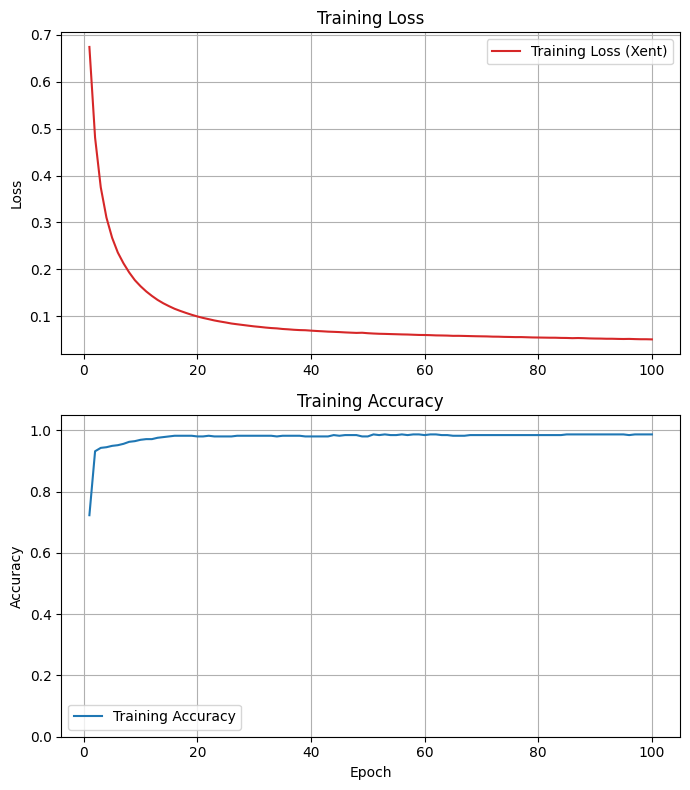

Final Training Loss:     0.0507
Final Training Accuracy: 0.9868

Results:
Training Accuracy: 0.9868
Testing Accuracy: 0.9474
Difference (Train - Test): 0.0394


In [31]:
# Your code here, add additional cells if you wish
# Build a network with a single hidden layer of 64 neurons using sigmoid activation
# Build model
model_64 = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation="sigmoid"),  # Hidden layer with 64 neurons
    keras.layers.Dense(1, activation="sigmoid")    # Output layer
])

# Print model summary
print("Model architecture:")
model_64.summary()

# Compile the model (same parameters as baseline like before)
model_64.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

# Use the same class weights as before
print(f"Using class weights: {class_weights}")

# Train the model
print("Training the model:")
history_64 = model_64.fit(
    X_train_scaled, y_train,
    epochs=n_epochs,
    class_weight=class_weights,
    verbose=1
)

# Plot training history
plot_history(history_64)

# Evaluate on test set
test_loss_64, test_accuracy_64 = model_64.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\nResults:")
print(f"Training Accuracy: {history_64.history['accuracy'][-1]:.4f}")
print(f"Testing Accuracy: {test_accuracy_64:.4f}")
print(f"Difference (Train - Test): {history_64.history['accuracy'][-1] - test_accuracy_64:.4f}")


In [32]:
# Set a3a to the final training accuracy
# Use the appropriate variable or expression; do not insert a constant from inspection of the results

a3a = history_64.history['accuracy'][-1]            # Replace 0.0 with your answer

In [33]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a:.4f}')

a3a = 0.9868


In [34]:
# Set a3b to the final testing accuracy
# Use the appropriate variable; do not insert a constant from inspection of the results

a3b = test_accuracy_64             # Replace 0.0 with your answer

In [35]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.9474


## Problem Four: Explore alternate network designs


For Problem Four, redo the work you did in Parts C and D of Problem One, but with a network with  a hidden layer of 256 neurons, using the sigmoid activation function, which
will have the following summary chart:

![Screenshot 2025-05-14 at 9.53.20 PM.png](attachment:464f1603-0ac4-4ca2-8f3e-affe3ee25b5a.png)


Then answer the graded questions.

Model architecture:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,193 (32.00 KB)

 Trainable params: 8,193 (32.00 KB)

 Non-trainable params: 0 (0.00 B)

Model compiled
Using class weights: {0: np.float64(1.338235294117647), 1: np.float64(0.7982456140350878)}
Training the model:
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6124 - loss: 0.5774
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9392 - loss: 0.3055
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9362 - loss: 0.2413
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9541 - loss: 0.1783
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9618 - loss: 0.1498  
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9759 - loss: 0.1421 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9883 - loss: 0.1112 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9782 - loss: 0.1284 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9788 - loss: 0.1164 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9787 - loss: 0.1107 
Epoch 11/100

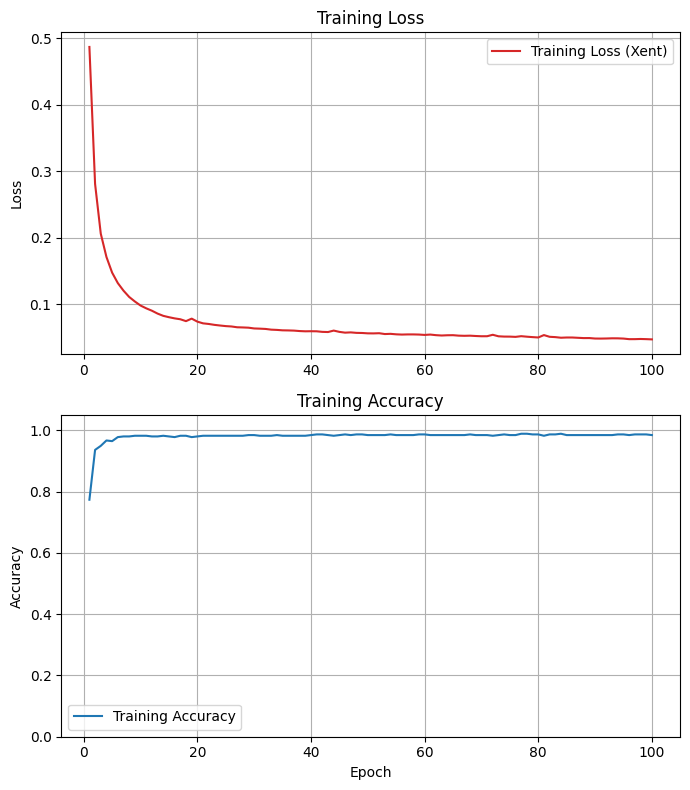

Final Training Loss:     0.0471
Final Training Accuracy: 0.9846

Results:
Training Accuracy: 0.9846
Testing Accuracy: 0.9474
Difference (Train - Test): 0.0372


In [36]:
# Your code here, add additional cells if you wish
# Build a network with a single hidden layer of 256 neurons using sigmoid activation
# Build the model
model_256 = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(256, activation="sigmoid"),  # Hidden layer with 256 neurons
    keras.layers.Dense(1, activation="sigmoid")     # Output layer
])

# Print model summary
print("Model architecture:")
model_256.summary()

# Compile the model (same parameters as baseline like before)
model_256.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model compiled")

# Use the same class weights as before
print(f"Using class weights: {class_weights}")

# Train the model
print("Training the model:")
history_256 = model_256.fit(
    X_train_scaled, y_train,
    epochs=n_epochs,
    class_weight=class_weights,
    verbose=1
)

# Plot training history
plot_history(history_256)

# Evaluate on test set
test_loss_256, test_accuracy_256 = model_256.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\nResults:")
print(f"Training Accuracy: {history_256.history['accuracy'][-1]:.4f}")
print(f"Testing Accuracy: {test_accuracy_256:.4f}")
print(f"Difference (Train - Test): {history_256.history['accuracy'][-1] - test_accuracy_256:.4f}")


In [37]:
# Set a4a to the final training accuracy
# Use the appropriate variable or expression; do not insert a constant from inspection of the results

a4a = history_256.history['accuracy'][-1]             # Replace 0.0 with your answer

In [38]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a:.4f}')

a4a = 0.9846


In [39]:
# Set a4b to the final testing accuracy
# Use the appropriate variable; do not insert a constant from inspection of the results

a4b = test_accuracy_256             # Replace 0.0 with your answer

In [40]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.9474


## Problem Five: Explore alternate network designs


For Problem Five, redo the work you did in Parts C and D of Problem One, but with a network with two hidden layers of 64  and 32 neurons, using the sigmoid activation function for all layers, which
will have the following summary chart:

![Screenshot 2025-05-14 at 9.52.42 PM.png](attachment:b6094f80-be1d-4ade-be21-44e24aab768f.png)

Then answer the graded questions.

Model architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

Model compiled
Using class weights: {0: np.float64(1.338235294117647), 1: np.float64(0.7982456140350878)}
Training the model:
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6268 - loss: 0.7382
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8656 - loss: 0.6285 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9443 - loss: 0.5379 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9371 - loss: 0.4529 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9230 - loss: 0.3822 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9442 - loss: 0.2967 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9467 - loss: 0.2502 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9587 - loss: 0.2107 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9601 - loss: 0.1858
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9660 - loss: 0.1703 
Epoch 11/100
15

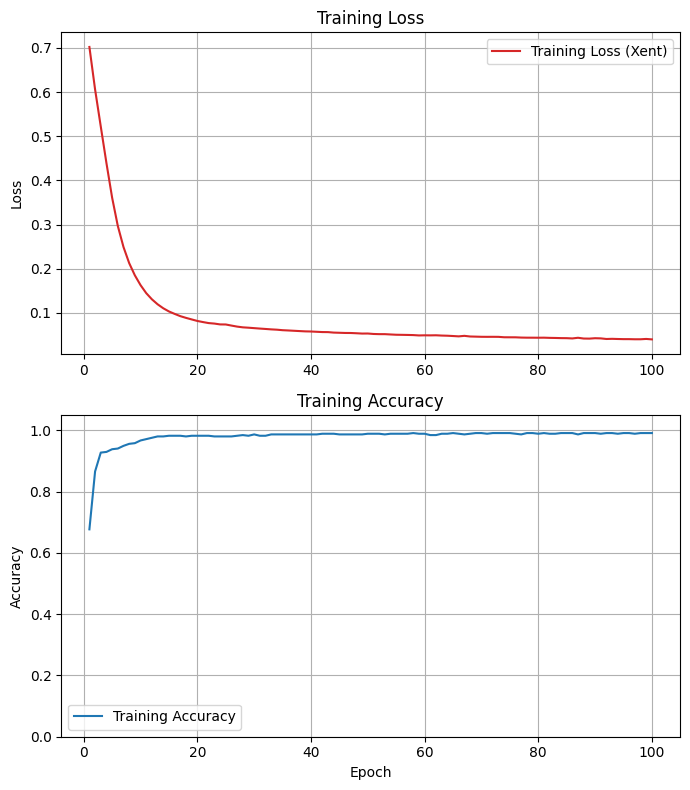

Final Training Loss:     0.0402
Final Training Accuracy: 0.9912

Results:
Training Accuracy: 0.9912
Testing Accuracy: 0.9474
Difference (Train - Test): 0.0438


In [41]:
# Your code here, add additional cells if you wish
# Build a network with two hidden layers of 64 and 32 neurons using sigmoid activation

# Build the model
model_two_layers = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation="sigmoid"),   # First hidden layer with 64 neurons
    keras.layers.Dense(32, activation="sigmoid"),   # Second hidden layer with 32 neurons
    keras.layers.Dense(1, activation="sigmoid")     # Output layer
])

# Print model summary
print("Model architecture:")
model_two_layers.summary()

# Compile the model (same parameters as baseline before)
model_two_layers.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model compiled")

# Use the same class weights as before
print(f"Using class weights: {class_weights}")

# Train the model
print("Training the model:")
history_two_layers = model_two_layers.fit(
    X_train_scaled, y_train,
    epochs=n_epochs,
    class_weight=class_weights,
    verbose=1
)

# Plot training history
plot_history(history_two_layers)

# Evaluate on test set
test_loss_two_layers, test_accuracy_two_layers = model_two_layers.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\nResults:")
print(f"Training Accuracy: {history_two_layers.history['accuracy'][-1]:.4f}")
print(f"Testing Accuracy: {test_accuracy_two_layers:.4f}")
print(f"Difference (Train - Test): {history_two_layers.history['accuracy'][-1] - test_accuracy_two_layers:.4f}")


In [42]:
# Set a5a to the final training accuracy
# Use the appropriate variable or expression; do not insert a constant from inspection of the results

a5a = history_two_layers.history['accuracy'][-1]             # Replace 0.0 with your answer

In [43]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5a = {a5a:.4f}')

a5a = 0.9912


In [44]:
# Set a5b to the final testing accuracy
# Use the appropriate variable; do not insert a constant from inspection of the results

a5b = test_accuracy_two_layers             # Replace 0.0 with your answer

In [45]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5b = {a5b:.4f}')

a5b = 0.9474


## Reflection Questions:

You won't be graded on these, and you don't need to write anything, but here are some things to think about after completing the experiments.

1. After the baseline, we tried wider and wider models, and then a deeper model. Which idea worked better in terms of training accuracy (at least for this data split)? What model would you try next to test this hypothesis?

2. What effect did these experiments have on the testing accuracy?  Can you suggest an explanation for this? Rather than me giving you ideas, have a conversation with `ChatGPT` in which you describe your experiments, and the dataset, and explore with it why the testing results turned out this way.

3. What do you think would happen if you tried running the same experiments with a different random seed (and hence a different split in a fairly small dataset)?  